### Ultimate Inc. Take Home Challenge


Solution for take home challenge


### Part 1


**Part 1 ‐ Exploratory data analysis**

The attached *logins.json* file contains (simulated) timestamps of user logins in a particular geographic location.<br/>
Aggregate these login counts based on 15­ minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. <br/>
Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import datetime
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix


#!pip install -U imbalanced-learn

In [2]:
json_df = pd.read_json('logins.json')

In [3]:
json_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
json_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [5]:
json_df.isnull().sum().sum()

0

In [6]:
print(json_df.dtypes, json_df.shape)

login_time    datetime64[ns]
dtype: object (93142, 1)


In [7]:
#resampling df to 15-minute intervals
login = json_df.resample("15min", on="login_time").count()

#cleaning up df
login.index.name = "index"
login.reset_index(inplace=True)
login.rename({"index":"logins"}, axis=1, inplace=True)

#show
login.head()

,logins,login_time
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [8]:
login['date'] = pd.to_datetime(login['logins'], format='%Y:%M:%D').dt.date
login['time'] = pd.to_datetime(login['logins'], format='%Y:%M:%D').dt.time
login['hour'] = pd.to_datetime(login['logins']).dt.hour
login['day'] = pd.to_datetime(login['logins']).dt.day_name()

m_or_e = lambda x: 'AM' if x in range (0,12) else 'PM'      # morning or evening
login['Mornings/Evenings'] = login['login_time'].apply(m_or_e)

login.head()

,logins,login_time,date,time,hour,day,Mornings/Evenings
0,1970-01-01 20:00:00,2,1970-01-01,20:00:00,20,Thursday,AM
1,1970-01-01 20:15:00,6,1970-01-01,20:15:00,20,Thursday,AM
2,1970-01-01 20:30:00,9,1970-01-01,20:30:00,20,Thursday,AM
3,1970-01-01 20:45:00,7,1970-01-01,20:45:00,20,Thursday,AM
4,1970-01-01 21:00:00,1,1970-01-01,21:00:00,21,Thursday,AM


In [9]:
print("The start time is:",min(login.time),','+\
" The end time is", max(login.time))


The start time is: 00:00:00 , The end time is 23:45:00


In [10]:
login['Mornings/Evenings'].value_counts()

AM    6787
PM    3001
Name: Mornings/Evenings, dtype: int64

#### Majority of logins were in the morning (AM)

In [11]:
login['day'].value_counts()

Saturday     1440
Friday       1440
Sunday       1440
Monday       1420
Thursday     1360
Wednesday    1344
Tuesday      1344
Name: day, dtype: int64

#### The maximum logins are observed during the weekend (Friday, Saturday and Sunday) followed by Monday

In [12]:
df_day = login.groupby("day").sum()[["login_time"]]

df_day["daily_avg"] = login.groupby("day").mean()[["login_time"]]

df_day

,login_time,daily_avg
day,,
Friday,15208,10.561111
Monday,8823,6.213380
Saturday,19377,13.456250
Sunday,18167,12.615972
Thursday,11960,8.794118
Tuesday,9268,6.895833
Wednesday,10339,7.692708


**The maximum number of logins (login_time) are observed on saturday and sunday with highest daily average on Saturday.<br/>
The least number of logins are observed on Monday with the least daily average**

### Hourly login trend

In [13]:
df_hour = login.groupby("hour").sum()[["login_time"]]

df_hour["avg"] = login.groupby("hour").mean()[["login_time"]]
df_hour.sort_values(by = 'login_time', ascending = False, inplace =True)
df_hour

,login_time,avg
hour,,
22,6607,16.193627
1,6317,15.482843
23,6058,14.848039
0,5993,14.688725
2,5800,14.215686
11,5799,14.213235
21,5623,13.781863
4,5034,12.338235
12,4964,12.166667


**Maximum number of logins occured at 10pm with 6607 logins followed by 1am with 6317 logins.<br/>
Maximum average of hourly logins was at 1pm with 15.4 logins per hour.**

**Most logins are observed during weekends and at nights**

In [14]:
df_daily = login.groupby(['hour', 'day']).sum()[["login_time"]]

df_daily["average"] = login.groupby(['hour', 'day']).mean()[["login_time"]]

df_daily.sort_values(by = 'login_time', inplace = True, ascending =False)
df_daily

login_time    average
hour day                             
4    Sunday           2107  35.116667
     Saturday         1719  28.650000
3    Sunday           1647  27.450000
2    Sunday           1608  26.800000
     Saturday         1608  26.800000
3    Saturday         1574  26.233333
1    Saturday         1562  26.033333
22   Friday           1519  25.316667
1    Sunday           1355  22.583333
23   Friday           1298  21.633333
0    Saturday         1254  20.900000
21   Friday           1206  20.100000
22   Saturday         1162  19.366667
0    Sunday           1123  18.716667
5    Sunday           1102  18.366667
11   Thursday         1097  19.589286
5    Saturday         1093  18.216667
22   Thursday         1089  18.150000
11   Wednesday        1057  18.875000
23   Thursday         1033  17.216667
11   Friday           1019  16.983333
     Tuesday          1015  18.125000
23   Saturday         1006  16.766667
0    Friday            975  16.250000
1    Friday            957  15.950000
11   Monday            947  15.783333
12   Friday            926  15.433333
23   Wednesday         908  16.214286
22   Wednesday         885  15.803571
21   Saturday          874  14.566667
...                    ...        ...
10   Saturday          204   3.400000
3    Tuesday           198   3.535714
7    Sunday            192   3.200000
17   Wednesday         192   3.428571
     Tuesday           183   3.267857
9    Sunday            180   3.000000
7    Saturday          178   2.966667
8    Sunday            153   2.550000
4    Tuesday           149   2.660714
8    Monday            147   2.450000
5    Thursday          136   2.428571
     Wednesday         135   2.410714
8    Saturday          127   2.116667
5    Monday            121   2.016667
6    Friday            121   2.016667
9    Saturday          118   1.966667
5    Tuesday           113   2.017857
7    Monday            111   1.850000
8    Friday            109   1.816667
7    Friday            105   1.750000
8    Wednesday          99   1.767857
     Thursday           95   1.696429
     Tuesday            88   1.571429
7    Wednesday          84   1.500000
     Thursday           81   1.446429
6    Thursday           67   1.196429
     Monday             66   1.100000
7    Tuesday            64   1.142857
6    Wednesday          48   0.857143
     Tuesday            46   0.821429

[168 rows x 2 columns]

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


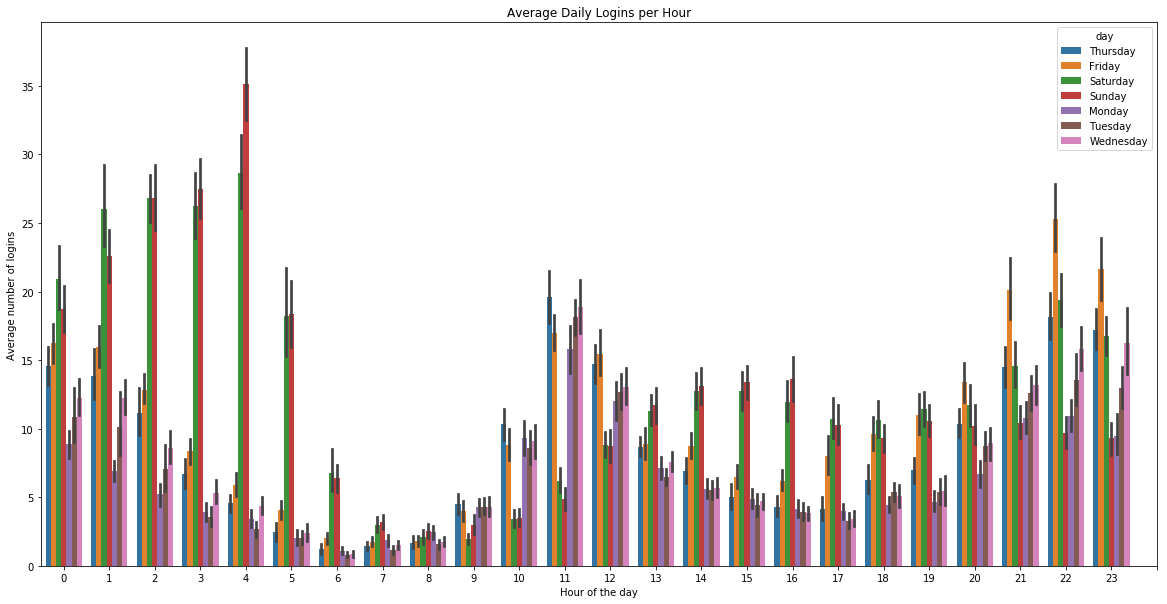

In [15]:
#getting average daily logins per hour
df_total = login.groupby(["hour", "day"]).mean().reset_index()

#plotting df
plt.figure(figsize=(20,10))
# ax = sns.lineplot(x="hour", y="login_time", data=login, hue="day")
sns.barplot( x="hour", y="login_time", data=login, hue="day")
plt.title("Average Daily Logins per Hour")
plt.xticks(range(0,25))
plt.xlabel ('Hour of the day')
plt.ylabel ('Average number of logins')

#display plot
plt.show()

**There are 3 peaks observed from the plot above. The first is at 4am where the average number of logins is maximum.
Again at 11am as well at 10 pm**

### Part 2


**Part 2 ‐ Experiment and metrics design** <br/>
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. <br/>
However, a toll bridge, with a two ­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs. <br/>
1. What would you choose as the key measure of success of this experiment in 
encouraging driver partners to serve both cities, and why would you choose this metric? 
2. Describe a practical experiment you would design to compare the effectiveness of the 
proposed change in relation to the key measure of success. Please provide details on: 
	a. how you will implement the experiment 
	b. what statistical test(s) you will conduct to verify the significance of the 
observation 
	c. how you would interpret the results and provide recommendations to the city operations team along with any caveats. 


**Answer**<br/>
From the above description, it is intitutive to conclude that Ultimate Metropolis has the most number of 
office/work spaces as this city is most active during the day. Most of the population appears to reside in Ultimate
Gotham city where the activity peaks at night time.



1. We can measure the success of the experiment (reimbursement of toll costs) by introducting A/B testing.
    1. The control group - retaining the tolls and checking the activity (number of cars passing through the tolls)
    2. The treatment group -  Reimburse all the tolls and measure the activity (or increased activity) and compare the metrics (activity/number of cars in and out of the city) metrics with the control group to decide whether reimbursing tolls have an impact on drivers being available in both the cities.

2. A practical experiment can be conducted by using Hypothesis testing where the null hypothesis being :<br/>
    *"There is no difference in the activity (availability in the number of cars) in both the cities after introducing reimbursement of toll costs"*<br/>
    1. Above null hypothesis can be tested by using a sample of the population (of driver partners) as the entire population (of both the cities) cannot be used for the test. We also need to ensure that the sample size is atleast > 30 (to apply central limit theorem and assuming the distribution is close to normal). 
    2. Sample should be from a single treatment group (reimbursed tolls). 
    3. Calculate z-score with the available data (using sample mean and sample std. deviation)
    4. Finding the confidence interval and verifying if the z-score falls in the confidence interval (using a Z score or standard distribution table)
    5. Accepting or rejecting null hypothesis based on the p-value arrived at with the z-score

### Part 3


**Part 3 ‐ Predictive modeling**

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.<br/>

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.<br/>

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained? 
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance. 
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­ term rider retention (again, a few sentences will suffice).

**Data description**

● city: city this user signed up in<br/>

● phone: primary device for this user<br/>

● signup_date: date of account registration; in the form ‘YYYY MM DD’<br/>

● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’<br/>

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup<br/>

● avg_rating_by_driver: the rider’s average rating over all of their trips<br/>

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips<br/>

● surge_pct: the percent of trips taken with surge multiplier > 1<br/>

● avg_surge: The average surge multiplier over all of this user’s trips<br/>

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up<br/>

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise<br/>

● weekday_pct: the percent of the user’s trips occurring during a weekday

### 1. Answer

In [16]:
data= open("ultimate_data_challenge.json", "r")          ##any easier way to load json instead of using json.loads
dataset = data.read()
data.close()

riders = json.loads(dataset)             # load is for a file, loads for a string

riders = pd.DataFrame(riders)
riders.head(4)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0


In [17]:
riders.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
ultimate_black_user          bool
weekday_pct               float64
dtype: object

  > - 'last_trip_date', 'signup_date' to be converted to 'datetime' datatype. Rest 'objects' to be converted to 'category'<br/>
   > - 'trips_in_first_30_days' indicates if the user is active or not. If this value is zero, it means that the user is not active



In [18]:
riders['active_user'] = [1 if x>0 else 0 for x in riders['trips_in_first_30_days']]
riders.head(3)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_user
0,3.67,5.0,4.7,1.1,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.0,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.0,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1


In [19]:
riders['active_user'].value_counts()

1    34610
0    15390
Name: active_user, dtype: int64

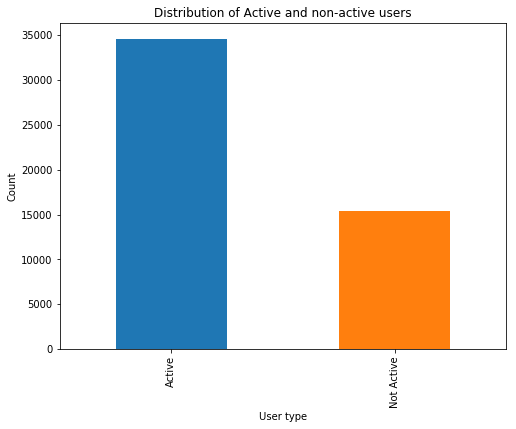

In [20]:
plt.figure(figsize = (8,6))
riders['active_user'].value_counts().plot(kind = 'bar')
labels = ('Active', 'Not Active')
positions = (0,1)
plt.xticks (positions, labels)
plt.xlabel('User type')
plt.ylabel ('Count')
plt.title ('Distribution of Active and non-active users')
plt.show()

In [21]:
active_riders_30 =pd.DataFrame(riders['active_user'].value_counts()).reset_index()
active_riders_30.columns = ['Active/passive', 'Count']
active_riders_30.replace({1: 'Active', 0: 'Passive'}, inplace = True)
active_riders_30

,Active/passive,Count
0,Active,34610
1,Passive,15390


There is a higher number of active users. However, the definition of 'active' was restricted to having taken a 'trips_in_first_30_days'.

#### Percentage of active users

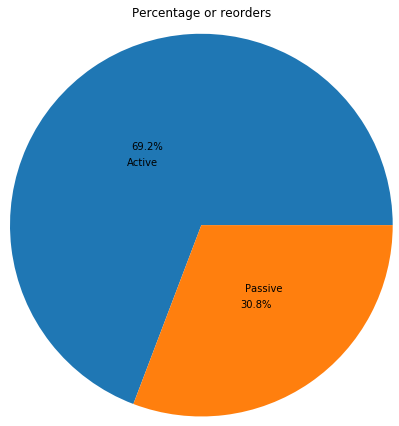

In [22]:
plt.pie('Count',autopct= '%1.1f%%',labels = 'Active/passive', pctdistance=0.5,\
        labeldistance=0.4, radius=2.2, data=active_riders_30)
plt.title('Percentage or reorders', loc = 'center', pad = 100)
plt.show()

### 2. Answer

**Converting dates to datetime format**

In [23]:
riders['last_trip_date'] = pd.to_datetime(riders['last_trip_date'])
riders['signup_date'] = pd.to_datetime(riders['signup_date'])

In [24]:
riders.dtypes

avg_dist                         float64
avg_rating_by_driver             float64
avg_rating_of_driver             float64
avg_surge                        float64
city                              object
last_trip_date            datetime64[ns]
phone                             object
signup_date               datetime64[ns]
surge_pct                        float64
trips_in_first_30_days             int64
ultimate_black_user                 bool
weekday_pct                      float64
active_user                        int64
dtype: object

**User active in the 6th month**

In [25]:
six_months_active = lambda x: 1 if ((x['last_trip_date'] - x['signup_date']) > timedelta(days = 30*5)) else 0

riders['six_months_active'] = riders.apply(six_months_active, axis = 1)

In [26]:
df_6m_active = riders[['signup_date', 'last_trip_date', 'six_months_active']]
df_6m_active.head(5)

,signup_date,last_trip_date,six_months_active
0,2014-01-25,2014-06-17,0
1,2014-01-29,2014-05-05,0
2,2014-01-06,2014-01-07,0
3,2014-01-10,2014-06-29,1
4,2014-01-27,2014-03-15,0


In [27]:
riders.head(3)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_user,six_months_active
0,3.67,5.0,4.7,1.1,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1,0
1,8.26,5.0,5.0,1.0,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0,0
2,0.77,5.0,4.3,1.0,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1,0


In [28]:
riders.dtypes

avg_dist                         float64
avg_rating_by_driver             float64
avg_rating_of_driver             float64
avg_surge                        float64
city                              object
last_trip_date            datetime64[ns]
phone                             object
signup_date               datetime64[ns]
surge_pct                        float64
trips_in_first_30_days             int64
ultimate_black_user                 bool
weekday_pct                      float64
active_user                        int64
six_months_active                  int64
dtype: object

In [29]:
riders.isna().any()

avg_dist                  False
avg_rating_by_driver       True
avg_rating_of_driver       True
avg_surge                 False
city                      False
last_trip_date            False
phone                      True
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
active_user               False
six_months_active         False
dtype: bool

The following columns have NaN values which need to be addressed :<br/>
   > - avg_rating_by_driver<br/>
   > - avg_rating_of_driver<br/>
   > - phone

We wil replace NaN values of avg_rating_by_driver and avg_rating_of_driver with Mean values of those columns respectively.

In [30]:
riders['avg_rating_by_driver'] = riders['avg_rating_by_driver'].replace (np.nan, riders["avg_rating_by_driver"].mean())
riders['avg_rating_of_driver'] = riders['avg_rating_of_driver'].replace (np.nan, riders["avg_rating_of_driver"].mean())

**Replacing NaN values in phone type with 'Other OS'**

In [31]:
riders['phone'] = riders['phone'].replace (np.nan, 'Other OS')

In [32]:
riders['phone'].unique()

array(['iPhone', 'Android', 'Other OS'], dtype=object)

In [33]:
riders.isna().any()

avg_dist                  False
avg_rating_by_driver      False
avg_rating_of_driver      False
avg_surge                 False
city                      False
last_trip_date            False
phone                     False
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
active_user               False
six_months_active         False
dtype: bool

**Replacing String values in 'ultimate_black_user'**

In [34]:
riders['ultimate_black_user'] = riders['ultimate_black_user'].replace (True, 1).replace(False, 0).astype('category')

In [35]:
riders.head(3)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_user,six_months_active
0,3.67,5.0,4.7,1.1,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,1.0,46.2,1,0
1,8.26,5.0,5.0,1.0,Astapor,2014-05-05,Android,2014-01-29,0.0,0,0.0,50.0,0,0
2,0.77,5.0,4.3,1.0,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,0.0,100.0,1,0


In [36]:
riders['ultimate_black_user'].dtype

CategoricalDtype(categories=[0.0, 1.0], ordered=False)

**All the columns are handled with their NaN values; For the modeling we will not be needing the 'datetime' columns
and will be dropping them**

In [37]:
riders.drop(['signup_date', 'last_trip_date'], axis =1, inplace = True)
riders.head(3)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_user,six_months_active
0,3.67,5.0,4.7,1.1,King's Landing,iPhone,15.4,4,1.0,46.2,1,0
1,8.26,5.0,5.0,1.0,Astapor,Android,0.0,0,0.0,50.0,0,0
2,0.77,5.0,4.3,1.0,Astapor,iPhone,0.0,3,0.0,100.0,1,0


In [38]:
riders['city'].unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [39]:
riders['phone'].unique()

array(['iPhone', 'Android', 'Other OS'], dtype=object)

In [40]:
riders['ultimate_black_user'].unique()

[1.0, 0.0]
Categories (2, float64): [1.0, 0.0]

In [41]:
riders['city'] = riders['city'].replace("King's Landing", 1).replace("Astapor", 2).replace("Winterfell" , 3)
riders['phone'] = riders['phone'].replace("iPhone", 1).replace("Android", 2).replace("Other OS" , 3)
riders['ultimate_black_user'] = riders['ultimate_black_user'].astype('int')
riders['city'] = riders['city'].astype('int')
riders['phone'] = riders['phone'].astype('int')
riders['active_user'] = riders['active_user'].astype('int')

### Modeling to predict retention

In [42]:
X = riders.drop(columns=['six_months_active', 'active_user'])   
##dropping six_months_active and active_user columns for better accuracy (as both intuitively have collinearity)

y = riders['six_months_active']  

In [43]:
X.head(3)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.1,1,1,15.4,4,1,46.2
1,8.26,5.0,5.0,1.0,2,2,0.0,0,0,50.0
2,0.77,5.0,4.3,1.0,2,1,0.0,3,0,100.0


In [44]:
labels = X.columns
labels

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'phone', 'surge_pct', 'trips_in_first_30_days',
       'ultimate_black_user', 'weekday_pct'],
      dtype='object')

In [45]:
y.value_counts()

0    37802
1    12198
Name: six_months_active, dtype: int64

**As we find class imbalance in the target class, we will upsample the underrepresented class and downsample the
overrepresented one.**

In [46]:
X.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                        int64
phone                       int64
surge_pct                 float64
trips_in_first_30_days      int64
ultimate_black_user         int64
weekday_pct               float64
dtype: object

### Scaling features using MinMaxScaler before doing train/test split

In [47]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.fit_transform(X)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =100, stratify = y)

In [49]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35000, 10) (15000, 10) (35000,) (15000,)


In [50]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 8539
Before OverSampling, counts of label '0': 26461 



In [51]:
sm = SMOTE(random_state=100)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, the shape of train_X: (52922, 10)
After OverSampling, the shape of train_y: (52922,) 

After OverSampling, counts of label '1': 26461
After OverSampling, counts of label '0': 26461


In [52]:
clf = DecisionTreeClassifier()
clf.fit(X_train_res, y_train_res)



y_pred = clf.predict(X_test)

# scores
print('Feature importances')
print(clf.feature_importances_)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

print("F1 Score :{}".format(f1_score(y_test, y_pred)))
print("Test accuracy:{}".format(accuracy_score(y_test, y_pred)*100))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

print('====Confusion Matrix=====')
print(confusion_matrix(y_test, y_pred))


Feature importances
[0.21722675 0.24606646 0.07497021 0.0401662  0.06262929 0.0232884
 0.07013289 0.14263877 0.02107765 0.10180338]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 Score :0.4473253618628068
Test accuracy:70.72666666666667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
====Confusion Matrix=====
[[8832 2509]
 [1882 1777]]


**Testing the accuracy using Random Forest Classifier and GridSearchCV**

In [53]:
params = {
    'max_depth': [4,5,6],
    'max_features': [3, 4, 5],
    'n_estimators': [14, 16, 20]
}

rf = RandomForestClassifier()

grid = GridSearchCV(estimator = rf, param_grid = params, cv =5)
grid.fit(X_train_res, y_train_res)

y_pred_grid = grid.predict(X_test)

print('Best parameters:{}'.format(grid.best_params_))


for feature in zip(labels, grid.best_estimator_.feature_importances_):
         print(feature)


############################################
#Random Forest model without GridSearchCV
############################################
# rf = RandomForestClassifier(n_estimators=1000, max_depth =5, random_state=100)
# rf.fit(X_train_res, y_train_res)

# y_pred_rf = rf.predict(X_test)

# labels = X.columns
# labels

# for feature in zip(labels, rf.feature_importances_ ):
#     print(feature)

# print('Accuracy score: ', accuracy_score(y_test, y_pred_rf)*100)

Best parameters:{'max_depth': 6, 'max_features': 4, 'n_estimators': 14}
('avg_dist', 0.008045878027424848)
('avg_rating_by_driver', 0.3314094876931399)
('avg_rating_of_driver', 0.0029919714254461657)
('avg_surge', 0.12982669144051764)
('city', 0.0978989734330182)
('phone', 0.044374935996813906)
('surge_pct', 0.11094676086250851)
('trips_in_first_30_days', 0.12803239173048434)
('ultimate_black_user', 0.014323399595907838)
('weekday_pct', 0.13214950979473852)


In [54]:
print('Accuracy score: ', round(grid.best_score_,2)*100)

Accuracy score:  78.0


We used Decision Tree and Random Forest Classifier for predicting if the user will be active in the 6th month.
We could also use Logistic regression for this purpose but Decision trees and RF Classifier handle any outliers better
than logistic regression (although we don't directly see any outliers in the data). As the number of categories in the categorical columns were less, they were replaced without using onehotencoder or get_dummies function.

With the above models, we arrived at an accuracy of 78%

### 3. Answer

The method with which we arrived at 'active' and 'passive' user is debatable. We have not considered the'average distance' criteria in assessing the user retention. Although we do not have additional data to back this up, in general, riding farther distances makes it economical and might make the 'user' become more 'active' than using other modes of transport.

As per the feature importances arrived at above, giving perks/discounts to long distance riders might help in retaining them as 'returning' customers. 
